In [ ]:
!pip install scikeras

In [ ]:
import nltk
import tensorflow as tf
import numpy as np
import random
import json
import pickle
from keras.models import load_model
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
stemmer = PorterStemmer()

In [ ]:
file_path = r'intents.json'
with open(file_path, 'r') as file:
    intents_data = json.load(file)

In [ ]:
import re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
words = []
classes = []
documents = []
ignore = ['?','.',',','"',"''",'!',]

for intent in intents_data['intents']:
    for pattern in intent['patterns']:
        html_pattern = re.compile('<.*?>')
    # Use the sub() function to replace HTML tags with an empty string
        clean_sentence = re.sub(html_pattern, '', pattern)
        w = word_tokenize(pattern)
        words.extend([lemmatizer.lemmatize(word.lower()) for word in w if word not in ignore])
        documents.append((w, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [ ]:
documents[:20]

[(['Hi'], 'greeting'),
 (['How', 'are', 'you', '?'], 'greeting'),
 (['Is', 'anyone', 'there', '?'], 'greeting'),
 (['Hello'], 'greeting'),
 (['Good', 'day'], 'greeting'),
 (['What', "'s", 'up'], 'greeting'),
 (['how', 'are', 'ya'], 'greeting'),
 (['heyy'], 'greeting'),
 (['whatsup'], 'greeting'),
 (['?', '?', '?', '?', '?', '?', '?', '?'], 'greeting'),
 (['cya'], 'goodbye'),
 (['see', 'you'], 'goodbye'),
 (['bye', 'bye'], 'goodbye'),
 (['See', 'you', 'later'], 'goodbye'),
 (['Goodbye'], 'goodbye'),
 (['I', 'am', 'Leaving'], 'goodbye'),
 (['Bye'], 'goodbye'),
 (['Have', 'a', 'Good', 'day'], 'goodbye'),
 (['talk', 'to', 'you', 'later'], 'goodbye'),
 (['ttyl'], 'goodbye')]

In [ ]:
len(words)

1345

In [ ]:
# from gensim.models import Word2Vec
# from nltk.tokenize import word_tokenize
# model = Word2Vec(sentences=words, vector_size=100, window=5, min_count=1, workers=4)
# model.train(words, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
words = sorted(list(set(words)))
classes = sorted(list(set(classes)))

In [ ]:
 training = []
 output = []
 output_empty = [0] * len(classes)

In [ ]:
 for doc in documents:
     bag = [1 if stemmer.stem(word.lower()) in [stemmer.stem(w) for w in doc[0]] else 0 for word in words]
     output_row = list(output_empty)
     output_row[classes.index(doc[1])] = 1
     training.append([bag, output_row])

In [ ]:
random.shuffle(training)
training = np.array(training, dtype='object')

In [ ]:
len(training)

405

In [ ]:
train_data = training[:350]
val_data = training[350:]

In [ ]:
train_x = list(train_data[:,0])
train_y = list(train_data[:,1])
val_x = list(val_data[:,0])
val_y = list(val_data[:,1])

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64,kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(len(train_x[0]),)))
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32,kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(train_y[0]), activation='softmax'))
model.compile(tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print(f"Shape of train_x: {np.array(train_x).shape}")
print(f"Shape of train_y: {np.array(train_y).shape}")
print(f"Shape of val_x: {np.array(val_x).shape}")
print(f"Shape of val_y: {np.array(val_y).shape}")

history = model.fit(np.array(train_x), np.array(train_y), validation_data=(np.array(val_x), np.array(val_y)),
                    epochs=1000, batch_size=8, verbose=1)

Shape of train_x: (350, 263)
Shape of train_y: (350, 38)
Shape of val_x: (55, 263)
Shape of val_y: (55, 38)
Epoch 1/1000
44/44 [==============================] - 1s 8ms/step - loss: 4.6953 - accuracy: 0.0486 - val_loss: 4.3950 - val_accuracy: 0.0727
Epoch 2/1000
44/44 [==============================] - 0s 4ms/step - loss: 4.1699 - accuracy: 0.1200 - val_loss: 4.0556 - val_accuracy: 0.0727
Epoch 3/1000
44/44 [==============================] - 0s 3ms/step - loss: 3.8721 - accuracy: 0.1486 - val_loss: 3.8657 - val_accuracy: 0.0727
Epoch 4/1000
44/44 [==============================] - 0s 3ms/step - loss: 3.6706 - accuracy: 0.1800 - val_loss: 3.7336 - val_accuracy: 0.0909
Epoch 5/1000
44/44 [==============================] - 0s 3ms/step - loss: 3.4973 - accuracy: 0.1943 - val_loss: 3.6368 - val_accuracy: 0.1455
Epoch 6/1000
44/44 [==============================] - 0s 3ms/step - loss: 3.3479 - accuracy: 0.2486 - val_loss: 3.5464 - val_accuracy: 0.1636
Epoch 7/1000
44/44 [====================

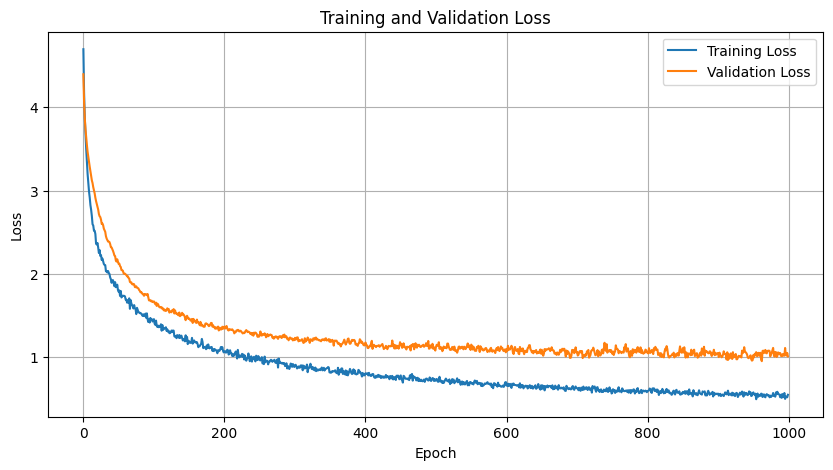

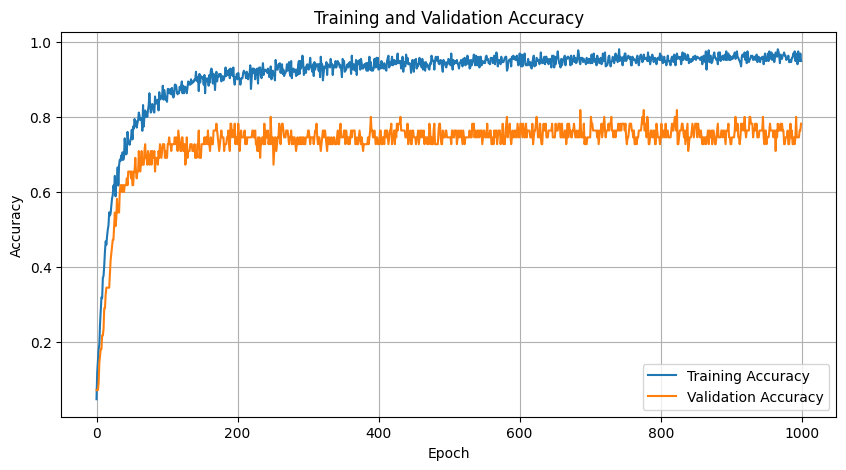

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
pickle.dump({'words': words, 'classes': classes}, open("training_data.pkl", "wb"))


In [ ]:
loaded_model = load_model("model.h5")
loaded_data = pickle.load(open("training_data.pkl", "rb"))
loaded_words = loaded_data['words']
loaded_classes = loaded_data['classes']

In [ ]:
# Function to clean up a sentence
def clean_up_sentence(sentence):
    sentence_words = word_tokenize(sentence)
    return [stemmer.stem(word.lower()) for word in sentence_words]

# Function to generate a bag of words array
def bow(sentence, words):
    sentence_words = clean_up_sentence(sentence)
    return [1 if stemmer.stem(word.lower()) in [stemmer.stem(w) for w in sentence_words] else 0 for word in words]


In [ ]:
ERROR_THRESHOLD = 0.30


In [ ]:
# Function to classify a sentence
def classify(sentence):
    bag = bow(sentence, loaded_words)
    results = loaded_model.predict(np.array([bag]))
    results = [(i, r) for i, r in enumerate(results[0]) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return [(loaded_classes[r[0]], r[1]) for r in results]

# Function to generate a response
# def response(sentence):
#     results = classify(sentence)
#     if results:
#         for i in intents_data['intents']:
#             if i['tag'] == results[0][0]:
#                 print(random.choice(i['responses']))
def response(sentence):
    # Classify the input sentence to obtain the results
    results = classify(sentence)

    # Check if classification results are available and not empty
    if results:
        # Get the tag and probability of the most likely class
        most_likely_tag, highest_probability = results[0]

        # Find the intent corresponding to the most likely tag
        for intent in intents_data['intents']:
            if intent['tag'] == most_likely_tag:
                # Print the response associated with the most likely intent
                #print(random.choice(intent['responses']))
                print(intent['responses'][0])

                break
    else:
        # Print a message indicating that no classification result was found
        print("please reframe your question")


In [ ]:
#Examples
response('hi')
response('what are the departments  in your university')
response('what are the courses offered by college')

1/1 [==============================] - 0s 30ms/step
Hello!
1/1 [==============================] - 0s 38ms/step
please reframe your question
1/1 [==============================] - 0s 21ms/step
please reframe your question
